In [1]:
import nibabel as nb
import os, sys
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import ptitprince as pt
import seaborn as sns
from scipy import stats
import matplotlib.gridspec as gridspec

from aidhs.aidhs_cohort_hip import AidhsCohort, AidhsSubject
from aidhs.paths import BASE_PATH
import random


Setting DATA_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals
Setting BASE_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals
Setting EXPERIMENT_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals
Setting PARAMS_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals
Setting FS_SUBJECTS_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals/output/fs_outputs
Setting HIPPUNFOLD_SUBJECTS_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals/output/hippunfold_outputs
Setting BIDS_SUBJECTS_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals/output/bids_outputs


### Load volumes

In [11]:
features_title = {
                '.hippunfold_volume_icvcorr' :'hippocampal volume\nicv-corrected (mm$^3$)',
                '.hippunfold_volume' :'hippocampal volume (mm$^3$)',
                '.FS_volume_icvcorr' :'FastSurfer hippocampal volume\nicv-corrected (mm$^3$)',
                '.FS_volume' :'FastSurfer hippocampal volume (mm$^3$)',
                
                '.total_volume' :'intracranial volume (mm$^3$)',
                
                '.curvature' : 'mean\ncurvature',
                '.gauss-curv_filtered': 'intrinsic\ncurvature ',
                '.gyrification' : 'gyrification ',
                '.thickness' : 'thickness',
                '.hippunfold_volume' :'volume',
    }

features=[
    '.label-avg.hippunfold_volume_icvcorr',
    '.label-avg.hippunfold_volume',
    '.label-avg.FS_volume_icvcorr',
    '.label-avg.FS_volume',
    '.label-avg.thickness.sm1',
    '.label-avg.gyrification.sm1',
    '.label-avg.curvature.sm1',
    '.label-avg.gauss-curv_filtered_sm1',

]

def return_features_title(feature, features_title):
    for feat in set(features_title):
        if feat in feature:
            return features_title[feat]


In [12]:
cohort = AidhsCohort(hdf5_file_root="{site_code}_{group}_featurematrix_smoothed_avg.hdf5", dataset='dataset_C-P-DC_alltrain.csv')

subjects = cohort.get_subject_ids(group='both', lesional_only = False)

hemis=['lh','rh']

In [13]:
# create dataframe with volumes
from aidhs.data_preprocessing import extract_totalbrainvolume_freesurfer


def is_nan(x):
    return (x != x)

ages = []

base_features=features


df=pd.DataFrame()
for subject in subjects:
    # create subject object
    subj = AidhsSubject(subject, cohort=cohort)
    group=subj.get_demographic_features("group")
    if group=='P':
        lesional_hemi = subj.get_demographic_features("Lesional hemi")
    elif group=='DC':
        lesional_hemi = random.choice(['lh','rh'])   #random choice
    else:
        lesional_hemi = random.choice(['lh','rh'])   #random choice
     #initialise segmentations folders
    id_FS, folder_FS = subj.get_demographic_features(["Freesurfer_ids", "Freesurfer_folder"])
    for hemi in hemis:
        values={}
        #get demographic info 
        values['ID']=subj.subject_id
        values['group']=group
        values['hemi'] = hemi
        values['site'], values['age_scan'], values['sex'], values['mri_neg'], values['age_onset'], values['epilepsy_duration']= subj.get_demographic_features(["Site","Age at preoperative", "Sex", "Ever reported MRI negative", "Age of onset of epilepsy","Duration of Epilepsy"])
        if is_nan(lesional_hemi):
            values['lesional'] = np.nan
        elif hemi==lesional_hemi:
            values['lesional'] = 'ipsi'
        else:
            values['lesional'] = 'contra'  
        #get structural and intensity features        
        for feature in features:
            vals = subj.load_feature_values(feature, hemi)
            if vals.sum()!=0:
                values[feature]=vals[0]
            else:
                pass 
        #get total ICV
        values['.label-avg.total_volume'] = extract_totalbrainvolume_freesurfer(os.path.join(folder_FS, id_FS))
        # save values for each subject in panda matrix
        df2 = pd.DataFrame([values])
        df = pd.concat([df,df2],ignore_index=True)


In [14]:
df

,ID,group,hemi,site,age_scan,sex,mri_neg,age_onset,epilepsy_duration,lesional,.label-avg.hippunfold_volume_icvcorr,.label-avg.hippunfold_volume,.label-avg.FS_volume_icvcorr,.label-avg.FS_volume,.label-avg.thickness.sm1,.label-avg.gyrification.sm1,.label-avg.curvature.sm1,.label-avg.gauss-curv_filtered_sm1,.label-avg.total_volume
0,MELDH29P0001,P,lh,H29,43.00,0.0,0.0,17.0,26.0,ipsi,1788.203003,1788.982056,3276.189697,3278.199951,1.431056,2.225459,0.175024,0.037335,1312003
1,MELDH29P0001,P,rh,H29,43.00,0.0,0.0,17.0,26.0,contra,2227.896973,2229.161621,4352.011719,4353.500000,1.474500,2.590247,0.164045,0.031597,1312003
2,MELDH29P0002,P,lh,H29,26.00,1.0,0.0,0.8,25.2,ipsi,1624.820679,1587.072632,3230.000000,3132.600098,1.373269,2.161435,0.208277,0.035482,1012007
3,MELDH29P0002,P,rh,H29,26.00,1.0,0.0,0.8,25.2,contra,2699.290527,2638.010986,4576.109375,4504.000000,1.464354,2.908666,0.157210,0.028598,1012007
4,MELDH29P0003,P,lh,H29,20.00,0.0,0.0,13.0,7.0,ipsi,1422.919189,1427.324463,3472.433105,3483.800049,1.433621,1.877874,0.188528,0.041268,1340239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,H16P0144,DC,rh,H16,19.00,1.0,1.0,NaN,NaN,contra,2070.602539,2119.609375,3834.432129,3892.100098,1.432728,2.486951,0.180697,0.029191,1541000
722,H16P0145,DC,lh,H16,25.58,0.0,0.0,NaN,NaN,ipsi,2300.082764,2326.157959,4450.419434,4517.700195,1.476196,2.646274,0.165850,0.029535,1508974
723,H16P0145,DC,rh,H16,25.58,0.0,0.0,NaN,NaN,contra,2481.559814,2523.889893,5017.289062,5067.100098,1.499834,2.793068,0.163253,0.027110,1508974
724,H16P0148,DC,lh,H16,21.50,0.0,0.0,NaN,NaN,ipsi,2494.479248,2522.791748,5083.446289,5156.500000,1.516654,2.732953,0.175100,0.027098,1526395


In [5]:
#load or save matrix
output_path=os.path.join(BASE_PATH, 'data_saved')
file = os.path.join(output_path,'matrix_features_intracranialvolumes_230920.csv')   
# df.to_csv(file)
df=pd.read_csv(file)

In [15]:
df.head()

,ID,group,hemi,site,age_scan,sex,mri_neg,age_onset,epilepsy_duration,lesional,.label-avg.hippunfold_volume_icvcorr,.label-avg.hippunfold_volume,.label-avg.FS_volume_icvcorr,.label-avg.FS_volume,.label-avg.thickness.sm1,.label-avg.gyrification.sm1,.label-avg.curvature.sm1,.label-avg.gauss-curv_filtered_sm1,.label-avg.total_volume
0,MELDH29P0001,P,lh,H29,43.0,0.0,0.0,17.0,26.0,ipsi,1788.203003,1788.982056,3276.189697,3278.199951,1.431056,2.225459,0.175024,0.037335,1312003
1,MELDH29P0001,P,rh,H29,43.0,0.0,0.0,17.0,26.0,contra,2227.896973,2229.161621,4352.011719,4353.500000,1.474500,2.590247,0.164045,0.031597,1312003
2,MELDH29P0002,P,lh,H29,26.0,1.0,0.0,0.8,25.2,ipsi,1624.820679,1587.072632,3230.000000,3132.600098,1.373269,2.161435,0.208277,0.035482,1012007
3,MELDH29P0002,P,rh,H29,26.0,1.0,0.0,0.8,25.2,contra,2699.290527,2638.010986,4576.109375,4504.000000,1.464354,2.908666,0.157210,0.028598,1012007
4,MELDH29P0003,P,lh,H29,20.0,0.0,0.0,13.0,7.0,ipsi,1422.919189,1427.324463,3472.433105,3483.800049,1.433621,1.877874,0.188528,0.041268,1340239


#### Plot raw volumes with age & sex

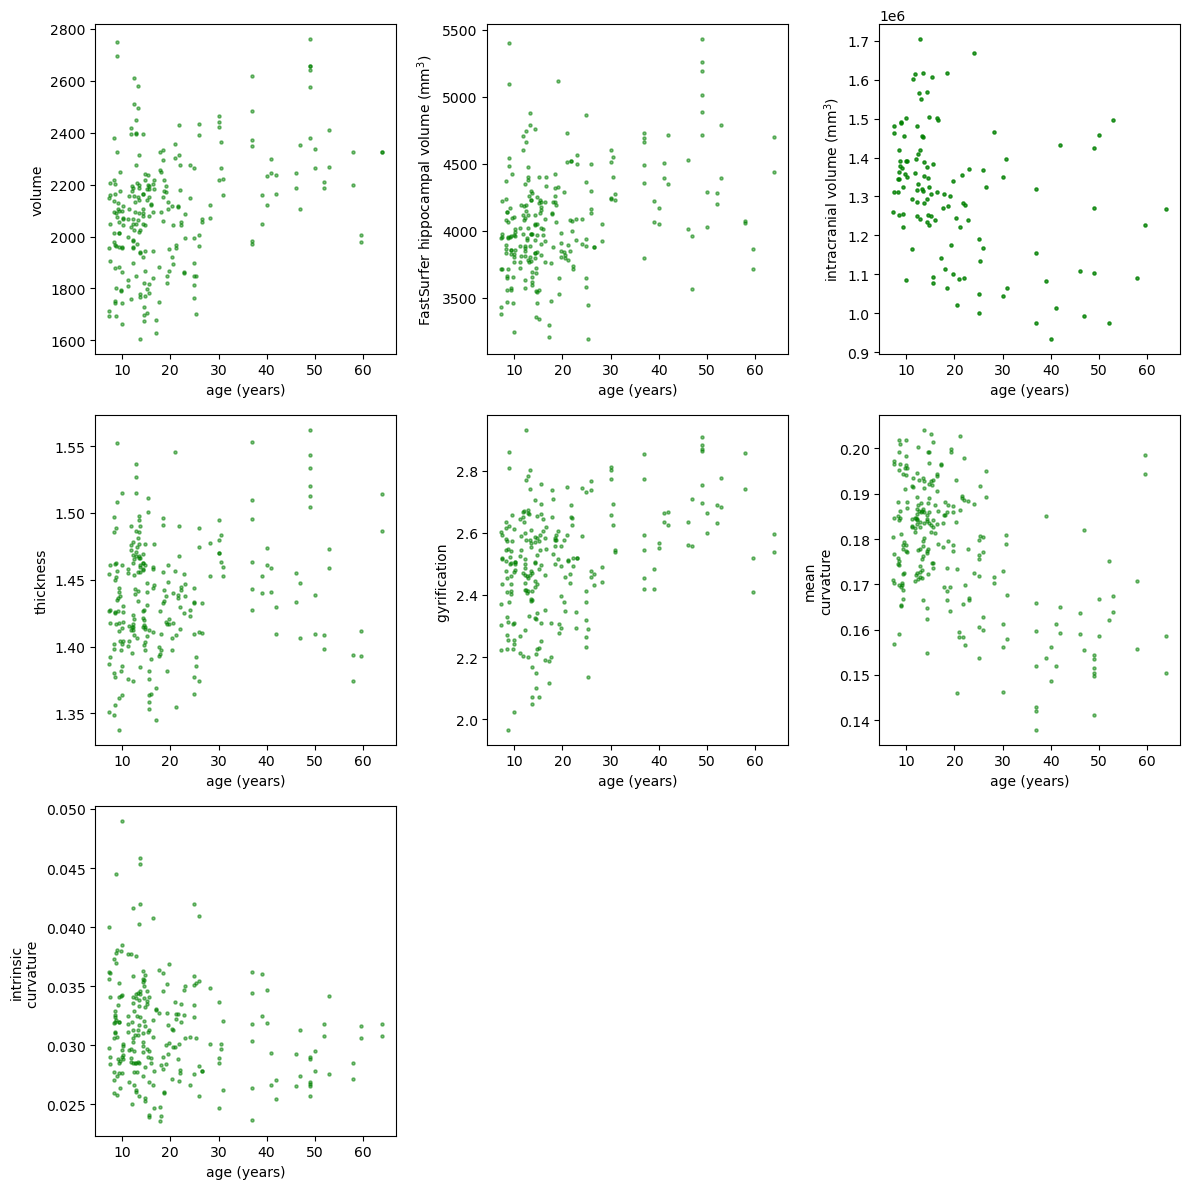

In [18]:

sexes=['male','female']
color = {'male':'blue', 'female':'pink',}
sub_features = ['.label-avg.hippunfold_volume','.label-avg.FS_volume', '.label-avg.total_volume',
                '.label-avg.thickness.sm1',
                '.label-avg.gyrification.sm1',
                '.label-avg.curvature.sm1',
                '.label-avg.gauss-curv_filtered_sm1',
                ]

fig = plt.figure(figsize=(12,12))
gs1 = gridspec.GridSpec(3, 3)
axs = []


for i,feature in enumerate(sub_features):
    axs.append(fig.add_subplot(gs1[i]))

    subdf = df.dropna(subset=[feature])

    #plot controls 
    subdf_c = subdf[subdf['group']=='C']
    sex_c = subdf_c['sex'].copy()
    age_c = subdf_c['age_scan'].copy()
    vals_c = subdf_c[feature].copy()
    axs[i].scatter(age_c,vals_c,c='green',s=5, alpha=0.5, label='healthy controls')
    axs[i].set_ylabel(return_features_title(feature, features_title))
    axs[i].set_xlabel('age (years)')

plt.tight_layout()

#### Plot correlation features with ICV 

In [19]:
# directory to save images
OUTPUT_PATH = os.path.join(BASE_PATH,'images')

.label-avg.hippunfold_volume
0.000168454608762334
1884.1797027504122
1305936.5867768596
pvalue 0.057
.label-avg.thickness.sm1
5.447050474899149e-08
1.3668089004903694
1305936.5867768596
pvalue 0.001
.label-avg.gyrification.sm1
6.977658804815397e-08
2.4132418833693885
1305936.5867768596
pvalue 0.329
.label-avg.curvature.sm1
1.8040958772262056e-08
0.154267585543427
1305936.5867768596
pvalue 0.001
.label-avg.gauss-curv_filtered_sm1
-2.1126379622608234e-09
0.034072144505383185
1305936.5867768596
pvalue 0.204


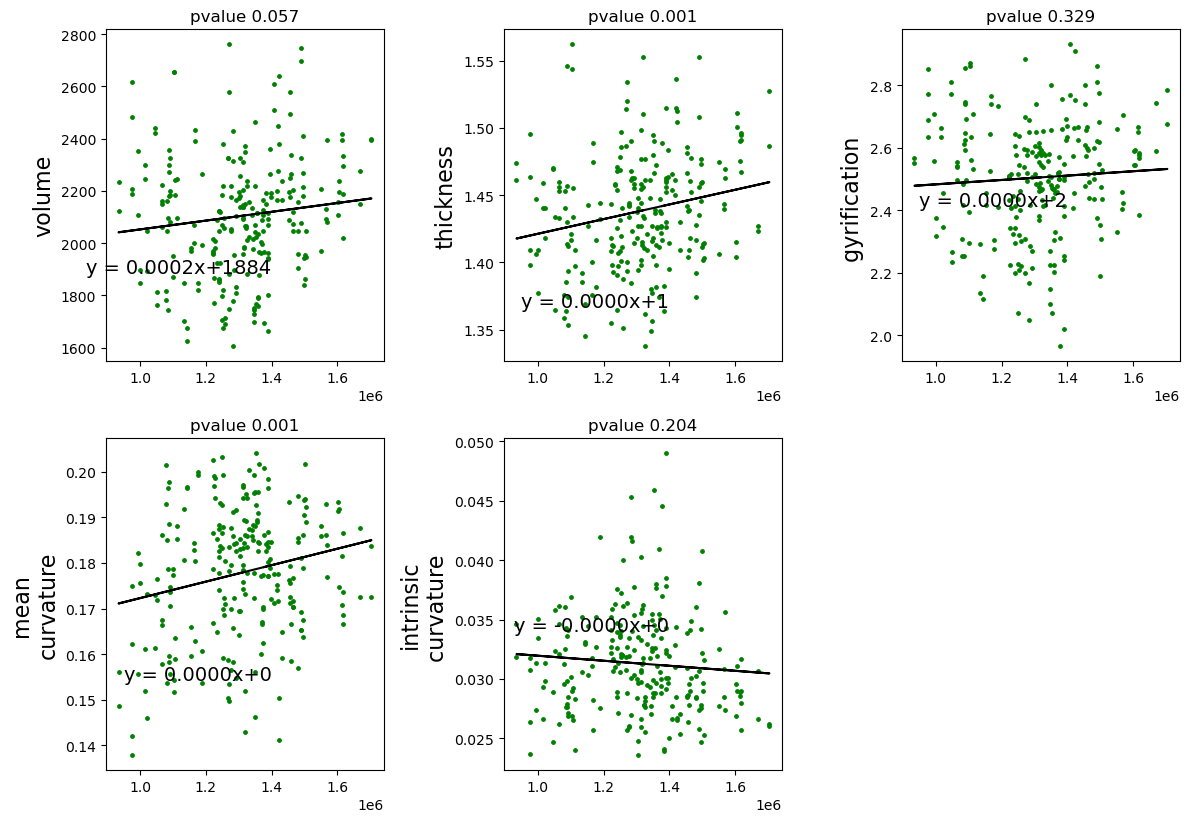

In [30]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

sub_features = ['.label-avg.hippunfold_volume', 
                # '.label-avg.FS_volume',
                '.label-avg.thickness.sm1',
                '.label-avg.gyrification.sm1',
                '.label-avg.curvature.sm1',
                '.label-avg.gauss-curv_filtered_sm1',
                ]
#select controls
df_c = df[df['group']=='C']

fig = plt.figure(figsize=(12,12))
gs1 = gridspec.GridSpec(3, 3)
axs = []

for i,feature in enumerate(sub_features):
    print(feature)
    axs.append(fig.add_subplot(gs1[i]))

    data = pd.DataFrame()
    data['feature']=df_c[feature].copy()
    data['ICV']=df_c['.label-avg.total_volume'].copy()
    # data['age']=df_c['age_scan'].copy()
    
    
    subdf = df_c.dropna(subset=[feature])
    axs[i].scatter(data['ICV'], data['feature'], s=6, color='green')
    axs[i].set_ylabel(return_features_title(feature, features_title), fontsize = 16)
    axs[i].set_xlabel(return_features_title('ICV', features_title), fontsize = 16)

    #fit linear regression
    res = smf.ols(f'feature ~ ICV', data=data).fit()
    # res = smf.ols(f'feature ~ ICV + age', data=data).fit()
    
    # print(res.summary())
    

    m = res.params['ICV']
    print(m)
    b = res.params['Intercept']
    print(b)

    mean_icv = data['ICV'].mean()
    print(mean_icv)
    
    p=res.pvalues['ICV']
    print(f'pvalue {p.round(3)}')
    
    axs[i].plot(data['ICV'], m*data['ICV']+b, color='black')
    axs[i].text(1.4e6,
                b,
                'y = {:.4f}x+{:d}'.format(m,int(b)),
                ha='right', fontsize=14)
    axs[i].set_title(f'pvalue {p.round(3)}')
plt.tight_layout()


# fig.savefig(f'{OUTPUT_PATH}/correlation_volume_icv.png', dpi=96, transparent =True, bbox_inches = 'tight')

In [ ]:
# # with sklearn
# from sklearn.linear_model import LinearRegression
# from sklearn.feature_selection import f_regression

# sub_features = ['.label-avg.hippunfold_volume', '.label-avg.FS_volume']
# #select controls
# df_c = df[df['group']=='C']

# fig = plt.figure(figsize=(12,5))
# gs1 = gridspec.GridSpec(1, 2)
# axs = []

# for i,feature in enumerate(sub_features):
#     axs.append(fig.add_subplot(gs1[i]))

#     subdf = df_c.dropna(subset=[feature])
#     axs[i].scatter(subdf['.label-avg.total_volume'], subdf[feature], s=6, color='green')
#     axs[i].set_ylabel(return_features_title(feature, features_title), fontsize = 16)
#     axs[i].set_xlabel(return_features_title('.label-avg.total_volume', features_title), fontsize = 16)

#     #fit linear regression
#     reg = LinearRegression().fit(subdf[['.label-avg.total_volume']], subdf[feature])
#     m = reg.coef_[0]
#     print(m)
#     b =reg.intercept_
#     print(b)

#     mean_icv = subdf['.label-avg.total_volume'].mean()
#     print(mean_icv)
    
#     freg=f_regression(subdf[['.label-avg.total_volume']], subdf[feature])
#     p=freg[1]
#     print(p.round(3))
    
#     axs[i].plot(subdf['.label-avg.total_volume'], m*subdf['.label-avg.total_volume']+b, color='black')
#     axs[i].text(1.4e6,
#                 b,
#                 'y = {:.4f}x+{:d}'.format(m,int(b)),
#                 ha='right', fontsize=14)
# plt.tight_layout()


# # fig.savefig(f'{OUTPUT_PATH}/correlation_volume_icv.png', dpi=96, transparent =True, bbox_inches = 'tight')